In [1]:
## Include packages

using DelimitedFiles
using DCAUtils
using Statistics
using KitMSA
using FastaIO
using LinearAlgebra
using StatsBase
using PyPlot
using Random
;

In [2]:
include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
include("../src/mutability.jl")
;

In [3]:
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)
;

In [18]:
path_nat = "../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
nat_msa = Int8.(fasta2matrix(path_nat))
w_nat = DCAUtils.compute_weights(Int8.(nat_msa'), 0.2)[1]
M, L = size(nat_msa)
f1_e, f2_e = DCAUtils.compute_weighted_frequencies(Int8.(nat_msa'), 22, 0.2)
f1_rs_e = reshape(f1_e, (21,L))
f2_rs_e = reshape(f2_e, (21,L,21,L))
c_e = triu(f2_e - f1_e*f1_e', 21)
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [19]:
entr_nat = CIE(nat_msa); 
cde_nat = zeros(size(nat_msa))
for s in 1:size(cde_nat,1)
    cde_nat[s,:] = cont_dep_entr_without_deg(nat_msa[s,:], h, J, q = 21) 
end
m_cde_nat = mean(cde_nat, weights(w_nat), dims = 1)[:];
var_cde_nat = [var(cde_nat[:,i], weights(w_nat)) for i in 1:76];

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [27]:
function proba_1_point(seq, h, J, N; q = 21, T = 1)
	prob = zeros(q,N)
    for site in 1:N
        norm = 0 
        for a in 1:q
            log_proba = h[a, site]
            for j in 1:N
                log_proba += J[a, seq[j], site, j]
            end
            prob[a,site] = exp(log_proba/T)
            norm += prob[a,site]
        end
        
        for a in 1:q
            prob[a,site] /= norm
        end
    end
    return prob
end

function single_proba_2_point(a, b, i, j, seq, h, J, N, T)
    log_proba = h[a, i] + h[b, j] + J[a, b, i, j]
    for k in 1:N
        if k !== j
            log_proba += J[a,seq[k], i, k]
        end
    end
    
    for l in 1:N
        if l !== i
            log_proba += J[seq[l], b, l, j]
        end
    end
    return exp(log_proba/T)
end


function dist_proba_2_point(i, j, seq, h, J, N, q, T) 
    res = zeros(q,q)
    norm = 0.
    for a in 1:q
        for b in 1:q
            res[a,b] = single_proba_2_point(a, b, i, j, seq, h, J, N, T)
            norm += res[a,b]
        end
    end
    return res/norm
end


function proba_2_point(seq, h, J, N; q = 21, T = 1) 
    res = zeros(q,L,q,L)
    for i in 1:L
        for j in 1:L
            res[:,i,:,j] = dist_proba_2_point(i, j, seq, h, J, N, q, T) 
        end
    end
    return res
end

function recursivefind!(metric::Array{Float64,4},threshold::Float64, coup_set, value::Int,site::Int,L::Int,q::Int)
    
    
    cand = [(i,ai) for i in 1:L for ai in 1:q if metric[value,site, ai, i] > threshold]
    new_cand = [couple for couple in cand if !(couple in coup_set)]
    if length(new_cand) == 0
        return coup_set
    else
        coup_set = vcat(coup_set, new_cand)
        for couple in new_cand
            coup_set = recursivefind!(metric,threshold,coup_set,couple[2],couple[1],L,q)
        end
    end
    return coup_set
end

recursivefind! (generic function with 1 method)

In [28]:
function clusterize(msa::Array{Int8,2}, cde_msa::Array{Float64,2}; 
        aa::Int=1, 
        site::Int=1,
        acc = 1e-4,
        n_points = 100)
    
    sub_msa = msa[(cde_msa[:, site] .< 1.) .&& (msa[:,site] .== aa), :]
    seq = msa[1,:]#sub_msa[rand(1:size(sub_msa,1)),:]
    
    q = Int(maximum(nat_msa))
    L = size(msa,2)
    p1_rs = proba_1_point(seq, h, J, L);
    p1 = reshape(p1_rs, L*21);
    p2_rs = proba_2_point(seq, h, J, L);
    p2 = reshape(p2_rs, (L*21, L*21));
    c_m = triu(p2 - p1*p1', 21)
    metric = reshape(c_m, (21, L, 21, L));
    
    n_points = round(Int, maximum(metric/acc))
    treshs = [acc*(i) for i in 1:n_points]
    cluster_length = zeros(n_points)
    clusters = []
    for i in 1:n_points
        coup_set = Tuple{Int, Int}[]
        push!(clusters, recursivefind!(metric, treshs[i], coup_set, aa, site, L, q))
        cluster_length[i] = length(clusters[end])
    end
    plt.plot(treshs, cluster_length)
    plt.xlabel("treshold")
    plt.ylabel("Cluster size")
    plt.title("aa_$(site)=$(aa)")
    savefig("../../cluster_a$(site)=$(aa).png")
    return seq, treshs, cluster_length, clusters, metric
end
        

clusterize (generic function with 1 method)

  1.648225 seconds (834.77 k allocations: 196.211 MiB, 0.93% gc time, 19.14% compilation time)


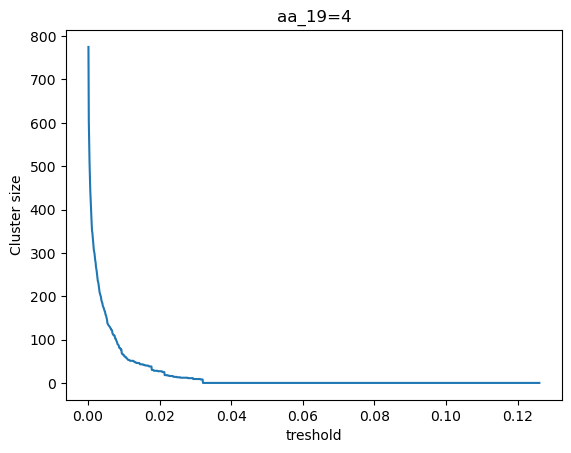

In [29]:
@time seq, treshs, cluster_length, clusters, metric = clusterize(nat_msa, cde_nat, 
    aa = 4, 
    site = 19, 
    acc = 1e-4, 
    n_points = 1000);

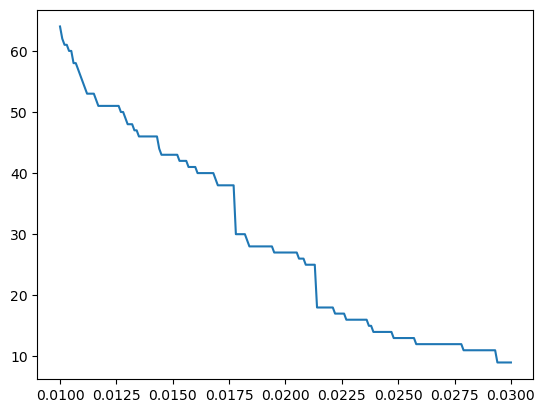

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f35c5281d30>

In [30]:
plt.plot(treshs[100:300], cluster_length[100:300])

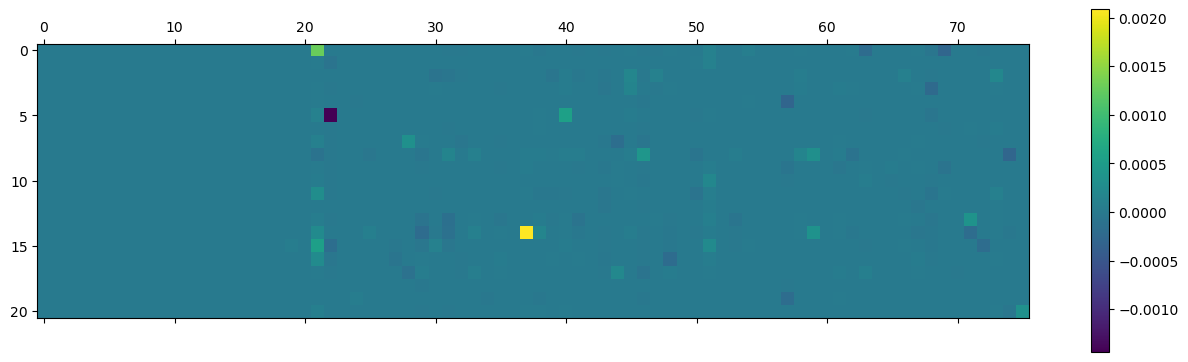

PyObject <matplotlib.colorbar.Colorbar object at 0x7f35c4013d60>

In [38]:
matshow(metric[15,19,:,:])
colorbar()